In [1]:
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,Conv2DTranspose,Input,Dense,Flatten,BatchNormalization,LeakyReLU,Dropout,Reshape
from keras.models import Sequential
import tensorflow as tf

In [2]:
import os 
import numpy as np

In [31]:
import matplotlib.pyplot as plt

In [4]:
root_dir = "F:/Code/jaskirat`s Sir/Semi-Supervised-Learning-for-Healthcare/MelanomaDetection"

In [5]:
unlabeled_datagen = ImageDataGenerator(featurewise_center=True , horizontal_flip=True ,vertical_flip=True ,
                                    rescale=1/255, brightness_range=(.5,1))

In [6]:
unlabeled_data = unlabeled_datagen.flow_from_directory(directory=root_dir,
                                                       classes = ["unlabeled"],
                                                       target_size = (32,32),
                                                       batch_size=256 )

Found 7018 images belonging to 1 classes.


In [8]:
def Discriminator():
    dis = Sequential(name = "Discriminator")
    
    dis.add(Conv2D(filters=64,kernel_size=4,strides=2,padding="same",input_shape=(32,32,3),use_bias=False))
    dis.add(LeakyReLU(alpha=0.2))
    
    dis.add(Conv2D(filters=128,kernel_size=4,strides=2,padding="same",use_bias=False))
    dis.add(BatchNormalization())
    dis.add(LeakyReLU(alpha=0.2))
    
    dis.add(Conv2D(filters=256,kernel_size=4,strides=2,padding="same",use_bias=False))
    dis.add(BatchNormalization())
    dis.add(LeakyReLU(alpha=0.2))
    
    dis.add(Flatten())
    dis.add(Dropout(0.4))
    
    dis.add(Dense(units = 1, activation = "sigmoid"  ))
    return dis


In [16]:
def Generator():
    noise = 100
    gen= Sequential(name= "Generator")
    
    gen.add(Input(shape=(noise,)))
    gen.add(Dense(units = 4*4*100 ,activation = "linear"))
    gen.add(Reshape((4,4,100)))
    
    gen.add(Conv2DTranspose(filters=256,kernel_size=4,strides=1,padding="same",use_bias=False))
    gen.add(BatchNormalization())
    gen.add(LeakyReLU(alpha=0.2))
    
    gen.add(Conv2DTranspose(filters = 128,kernel_size=4, strides = 2 ,padding ="same", use_bias = False))
    gen.add(BatchNormalization())
    gen.add(LeakyReLU(alpha = 0.2))
            
    gen.add(Conv2DTranspose(filters = 64 , kernel_size = 4, strides =2 ,padding ="same" ,use_bias =False))
    gen.add(BatchNormalization())
    gen.add(LeakyReLU(alpha =0.2))
            
    gen.add(Conv2DTranspose(filters = 3 ,kernel_size =4, strides =2 ,padding ="same" ,use_bias =False))
    
    return gen

In [10]:
D = Discriminator()

In [11]:
D.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        3072      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         131072    
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 128)        512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         524288    
                                                     

In [20]:
tf.keras.utils.plot_model(model=D,show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [17]:
G = Generator()

In [18]:
G.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1600)              161600    
                                                                 
 reshape (Reshape)           (None, 4, 4, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        409600    
 nspose)                                                         
                                                                 
 batch_normalization_2 (Batc  (None, 4, 4, 256)        1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 128)        52

In [19]:
tf.keras.utils.plot_model(model=G,show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [30]:
generated_image = G(random_noise)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


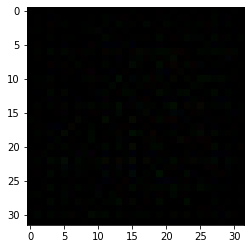

In [35]:
plt.imshow(generated_image[0,:,:,:])

In [37]:
posterior_prob_dis = D(generated_image)
print(posterior_prob_dis)

tf.Tensor([[0.5002174]], shape=(1, 1), dtype=float32)


In [40]:
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False ,label_smoothing=0.05)

In [41]:
def Dis_loss(real_img , fake_img_preds):
    real_img_labels = tf.ones_like(real_img)
    fake_img_labels = tf.zeros_like(fake_img_preds)
    
    real_img_loss = bce_loss(y_true=real_img,y_pred=real_img_labels)
    fake_img_pred_loss = bce_loss(y_true=fake_img_preds , y_pred=fake_img_labels)
    
    total_loss = real_img_loss + fake_img_pred_loss
    return loss      

In [42]:
def G_loss(fake_img_preds):
    fake_img_labels = tf.zeros_like(fake_img_preds)
    return bce_loss(y_true=fake_img_preds ,y_pred = fake_img_preds)

In [43]:
D_optimizers = tf.keras.optimizers.Adam(learning_rate=0.008 ,beta_1 = 0.3)
G_optimizers = tf.keras.optimizers.Adam(learning_rate=0.004 , beta_1 = 0.1 )

In [47]:
ckpt_dir_path = os.path.join(root_dir,"Checkpoint")
# Gan_checkpoint_dir = os.mkdir(ckpt_dir_path)
Gan_checkpoint_dir_prefix =os.path.join(ckpt_dir_path,"ckpt")
GAN_ckeckpoint = tf.train.Checkpoint(optimizer = [D_optimizers,G_optimizers] , model = [D,G])

In [39]:
random_noise = tf.random.normal(shape=(1,100),seed = 32,name = "Random Noise")
epochs = 100
batch_size = 256

In [48]:
@tf.function
def time_step(real_img):
    G.trainable = False
    noise = tf.random.normal(shape=(batch_size,random_noise))
    Fake_img_gen_mini_batch = G(noise,trainable = False)
    
    D.trainable = True
    
    with tf.GradientTape() as disc_tape ,tf.GradientTape() as gen_tape:
        real_img_preds = D(real_img ,training =True)
        fake_img_preds = D(Fake_img_gen_mini_batch ,training = True)
        
        D_loss = Dis_loss(real_img_preds , fake_img_preds)
        gradient_of_disc = disc_tape.gradient(D_loss ,D.trainable_weights)
        D_optimizers.apply_gradients(zip(gradient_of_disc,D.trainable_variables))
        
        G.trainable = True
        D.trainable = False
        
        noise = tf.random.normal(shape = (batch_size,random_noise))
        Fake_img_gen_mini_batch = G(noise,training = True)
        
        Gen_loss = G_loss(fake_img_preds= Fake_img_gen_mini_batch , training =True)
        gradient_of_gen = gen_tape.gradient(Gen_loss , G.trainable_variables)
        G_optimizers.apply_gradients(zip(Gen_loss ,G.trainable_variables))

In [56]:
num= 99
print("{:04}".format(num))
%04

0099
